In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import torch
from tqdm import tqdm
from sphere import logarithmic_map, exponential_map
import pandas as pd
pd.set_option('display.max_columns', None)

In [4]:
from model import Model
M = Model(root_dir='./')

In [5]:
M.load_vocab(M.categories, root_dir=M.root_dir)
M.encode_vocab(M.categories)

adverbs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3621/3621 [00:00<00:00, 835951.94it/s]


example noun:  Petromyzoniformes


Encoding adverbs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3910/3910 [00:49<00:00, 79.78it/s]


In [6]:
lam = 0.5
e = {'N': M.E['N'].clone(), 'V': M.E['V'].clone(), 'AV': M.E['AV'].clone(), 'A': M.E['A'].clone()}
W, m = M.decompose(categories=['N', 'A', 'V', 'AV'], encodings=e, lam=lam, zero_mean=True)

In [7]:
lamt = 0.5
en = {'N': M.E['N'].clone(), 'V': M.E['V'].clone(), 'AV': M.E['AV'].clone(), 'A': M.E['A'].clone()}

Wt, mt = M.decompose_tangent(categories=['N', 'A', 'V', 'AV'], encodings=en, lam=lamt, zero_mean=True)
print(f'mean value of intrinsic mean: {torch.norm(M.i_mean)}')

mean value of intrinsic mean: 1.0


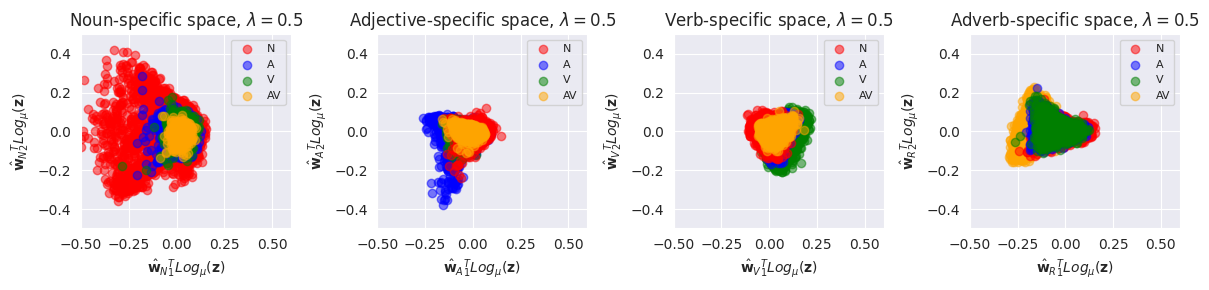

In [9]:
from sphere import logarithmic_map
%matplotlib inline

sns.set_style('darkgrid')

def plot_tangent_subspace(ax, W, m, name, lam, marker='+', n=5000, zorder=[1,2,3,4]):
    N = (W.T @ (logarithmic_map(M.i_mean, en['N'][:n])-m).T).T.detach().cpu().numpy()
    A = (W.T @ (logarithmic_map(M.i_mean, en['A'][:n])-m).T).T.detach().cpu().numpy()
    V = (W.T @ (logarithmic_map(M.i_mean, en['V'][:n])-m).T).T.detach().cpu().numpy()
    AV = (W.T @ (logarithmic_map(M.i_mean, en['AV'][:n])-mt).T).T.detach().cpu().numpy()

    ax.scatter(N[:, 0], N[:, 1], marker=marker, c='red', alpha=0.5, label='N', zorder=zorder[0], rasterized=True)
    ax.scatter(A[:, 0], A[:, 1], marker=marker, c='blue', alpha=0.5, label='A', zorder=zorder[1], rasterized=True)
    ax.scatter(V[:, 0], V[:, 1], marker=marker, c='green', alpha=0.5, label='V', zorder=zorder[2], rasterized=True)
    ax.scatter(AV[:, 0], AV[:, 1], marker=marker, c='orange', alpha=0.5, label='AV', zorder=zorder[3], rasterized=True)
    
    abv = name[0] if name != 'Adverb' else 'R'
    ax.set_xlabel(f'${{\hat{{\mathbf{{w}}}}_{abv}}}^T_1 Log_{{\mu}}( \mathbf{{z}} )$')
    ax.set_ylabel(f'${{\hat{{\mathbf{{w}}}}_{abv}}}^T_2 Log_{{\mu}}( \mathbf{{z}} )$')
    ax.set_title(f'{name}-specific space, $\lambda={lam}$')
    ax.legend(fontsize=8)
    
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlim([-0.5, 0.6])
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))

plot_tangent_subspace(ax1, Wt['N'], mt, marker='o', name='Noun', lam=lamt)
plot_tangent_subspace(ax2, Wt['A'], mt, marker='o', name='Adjective', lam=lamt, zorder=[3,1,2,4])
plot_tangent_subspace(ax3, Wt['V'], mt, marker='o', name='Verb', lam=lamt, zorder=[3,2,1,4])
plot_tangent_subspace(ax4, Wt['AV'], mt, marker='o', name='Adverb', lam=lamt, zorder=[2,3,4,1])
plt.tight_layout()

# Zero-shot classification

Code to reproduce the ZS classification experiments (Tab. 1 in the paper).

Note that pytorch's datasets module has since encounted many issues (e.g. [this](https://github.com/pytorch/vision/issues/7545)) with multiple datasets having deadlinks, so you'll manually have to download a fair number of datasets of interest below from elsewhere.

In [10]:
# load the imagenet1k classname strings
from class_names import IN_map
IN_map = [IN_map[x].split(',')[0] for x in IN_map.keys()]

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor

root = '../../datasets/' # replace the root with desired with location on disk

ds = [
    ('StanfordCars', datasets.StanfordCars(root=root, download=True), list(datasets.StanfordCars(root=root).classes)),
    ('Caltech101', datasets.Caltech101(root=root, download=True, target_transform=lambda y: 0 if y==1 or y==0 else y-1, transform=ToTensor()) ,  ['Faces', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler', 'starfish', 'stegosaurus', 'stop_sign', 'strawberry', 'sunflower', 'tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']),
    ('Food101', datasets.Food101(root=root, download=True) , ['apple pie', 'baby back ribs', 'baklava', 'beef carpaccio', 'beef tartare', 'beet salad', 'beignets', 'bibimbap', 'bread pudding', 'breakfast burrito', 'bruschetta', 'caesar salad', 'cannoli', 'caprese salad', 'carrot cake', 'ceviche', 'cheesecake', 'cheese plate', 'chicken curry', 'chicken quesadilla', 'chicken wings', 'chocolate cake', 'chocolate mousse', 'churros', 'clam chowder', 'club sandwich', 'crab cakes', 'creme brulee', 'croque madame', 'cup cakes', 'deviled eggs', 'donuts', 'dumplings', 'edamame', 'eggs benedict', 'escargots', 'falafel', 'filet mignon', 'fish and chips', 'foie gras', 'french fries', 'french onion soup', 'french toast', 'fried calamari', 'fried rice', 'frozen yogurt', 'garlic bread', 'gnocchi', 'greek salad', 'grilled cheese sandwich', 'grilled salmon', 'guacamole', 'gyoza', 'hamburger', 'hot and sour soup', 'hot dog', 'huevos rancheros', 'hummus', 'ice cream', 'lasagna', 'lobster bisque', 'lobster roll sandwich', 'macaroni and cheese', 'macarons', 'miso soup', 'mussels', 'nachos', 'omelette', 'onion rings', 'oysters', 'pad thai', 'paella', 'pancakes', 'panna cotta', 'peking duck', 'pho', 'pizza', 'pork chop', 'poutine', 'prime rib', 'pulled pork sandwich', 'ramen', 'ravioli', 'red velvet cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed salad', 'shrimp and grits', 'spaghetti bolognese', 'spaghetti carbonara', 'spring rolls', 'steak', 'strawberry shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna tartare', 'waffles']),
    ('cifar10', datasets.CIFAR10(root=root, transform=ToTensor(), download=True) , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
    ('cifar100', datasets.CIFAR100(root=root, download=True) , ['apple', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak tree', 'orange', 'orchid', 'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow tree', 'wolf', 'woman', 'worm']),
    ('OxfordPets', datasets.OxfordIIITPet(root=root, download=True) , sorted(['abyssinian', 'bengal', 'bombay', 'birman', 'british shorthair', 'maine coon', 'persian', 'egyptian mau', 'ragdoll', 'russian blue', 'siamese', 'sphynx', 'boxer', 'keeshond', 'havanese', 'basset hound', 'english setter', 'miniature pinscher', 'chihuahua', 'great pyrenees', 'german shorthaired', 'beagle', 'staffordshire bull terrier', 'english cocker spaniel', 'new found land', 'pomeranian', 'leonberger', 'american pit bull terrier', 'wheaten terrier', 'japanese chin', 'samyod', 'scottish terrier', 'shiba inu', 'pug', 'saint bernard', 'american bulldog', 'yorkshire terrier'])),
    ('Flowers102', datasets.Flowers102(root=root, target_transform=lambda x: x-1, download=True) , ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']),
    ('Caltech256', datasets.Caltech256(root=root, download=True, transform=ToTensor()) , ['ak47', 'american flag', 'backpack', 'baseball bat', 'baseball glove', 'basketball hoop', 'bat', 'bathtub', 'bear', 'beer mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai', 'boom box', 'bowling ball', 'bowling pin', 'boxing glove', 'brain', 'breadmaker', 'buddha', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car tire', 'cartman', 'cd', 'centipede', 'cereal box', 'chandelier', 'chess board', 'chimp', 'chopsticks', 'cockroach', 'coffee mug', 'coffin', 'coin', 'comet', 'computer keyboard', 'computer monitor', 'computer mouse', 'conch', 'cormorant', 'covered wagon', 'cowboy hat', 'crab', 'desk globe', 'diamond ring', 'dice', 'dog', 'dolphin', 'doorknob', 'drinking straw', 'duck', 'dumb bell', 'eiffel tower', 'electric guitar', 'elephant', 'elk', 'ewer', 'eyeglasses', 'fern', 'fighter jet', 'fire extinguisher', 'fire hydrant', 'fire truck', 'fireworks', 'flashlight', 'floppy disk', 'football helmet', 'french horn', 'fried egg', 'frisbee', 'frog', 'frying pan', 'galaxy', 'gas pump', 'giraffe', 'goat', 'golden gate bridge', 'goldfish', 'golf ball', 'goose', 'gorilla', 'grand piano', 'grapes', 'grasshopper', 'guitar pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill', 'head phones', 'helicopter', 'hibiscus', 'homer simpson', 'horse', 'horseshoe crab', 'hot air balloon', 'hot dog', 'hot tub', 'hourglass', 'house fly', 'human skeleton', 'hummingbird', 'ibis', 'ice cream cone', 'iguana', 'ipod', 'iris', 'jesus christ', 'joy stick', 'kangaroo', 'kayak', 'ketch', 'killer whale', 'knife', 'ladder', 'laptop', 'lathe', 'leopards', 'license plate', 'lightbulb', 'light house', 'lightning', 'llama', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes', 'mountain bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm pilot', 'palm tree', 'paperclip', 'paper shredder', 'pci card', 'penguin', 'people', 'pez dispenser', 'photocopier', 'picnic table', 'playing card', 'porcupine', 'pram', 'praying mantis', 'pyramid', 'raccoon', 'radio telescope', 'rainbow', 'refrigerator', 'revolver', 'rifle', 'rotary phone', 'roulette wheel', 'saddle', 'saturn', 'school bus', 'scorpion', 'screwdriver', 'segway', 'self propelled lawn mower', 'sextant', 'sheet music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer ball', 'socks', 'soda can', 'spaghetti', 'speed boat', 'spider', 'spoon', 'stained glass', 'starfish', 'steering wheel', 'stirrups', 'sunflower', 'superman', 'sushi', 'swan', 'swiss army knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy bear', 'teepee', 'telephone box', 'tennis ball', 'tennis court', 'tennis racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top hat', 'touring bike', 'tower pisa', 'traffic light', 'treadmill', 'triceratops', 'tricycle', 'trilobite', 'tripod', 't shirt', 'tuning fork', 'tweezer', 'umbrella', 'unicorn', 'vcr', 'video projector', 'washing machine', 'watch', 'waterfall', 'watermelon', 'welding mask', 'wheelbarrow', 'windmill', 'wine bottle', 'xylophone', 'yarmulke', 'yo yo', 'zebra', 'airplanes', 'car side', 'faces', 'greyhound', 'tennis shoes', 'toad', 'clutter']),
    ('stl10', datasets.STL10(root=root, download=True) , ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']),
    ('MNIST', datasets.MNIST(root=root, download=True) , [str(x) for x in list(range(9))]),
    ('DTD', datasets.DTD(root=root, download=True) , ['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']),
    ('FER2013', datasets.FER2013(root=root) , ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']),
    # NOTE: ImageFolder datasets need their paths specified:
    ('MIT-states', datasets.ImageFolder(f'{root}/noun_images'), ['aluminum', 'animal', 'apple', 'armor', 'bag', 'ball', 'balloon', 'banana', 'basement', 'basket', 'bathroom', 'bay', 'beach', 'bean', 'bear', 'bed', 'beef', 'belt', 'berry', 'bike', 'blade', 'boat', 'book', 'bottle', 'boulder', 'bowl', 'box', 'bracelet', 'branch', 'brass', 'bread', 'bridge', 'bronze', 'bubble', 'bucket', 'building', 'bus', 'bush', 'butter', 'cabinet', 'cable', 'cake', 'camera', 'candle', 'candy', 'canyon', 'car', 'card', 'carpet', 'castle', 'cat', 'cave', 'ceiling', 'ceramic', 'chains', 'chair', 'cheese', 'chicken', 'chocolate', 'church', 'city', 'clay', 'cliff', 'clock', 'clothes', 'cloud', 'coal', 'coast', 'coat', 'coffee', 'coin', 'column', 'computer', 'concrete', 'cookie', 'copper', 'cord', 'cotton', 'creek', 'deck', 'desert', 'desk', 'diamond', 'dirt', 'dog', 'door', 'dress', 'drum', 'dust', 'eggs', 'elephant', 'envelope', 'fabric', 'fan', 'farm', 'fence', 'field', 'fig', 'fire', 'fish', 'flame', 'floor', 'flower', 'foam', 'forest', 'frame', 'fruit', 'furniture', 'garage', 'garden', 'garlic', 'gate', 'gear', 'gemstone', 'glass', 'glasses', 'granite', 'ground', 'handle', 'hat', 'highway', 'horse', 'hose', 'house', 'ice', 'iguana', 'island', 'jacket', 'jewelry', 'jungle', 'key', 'keyboard', 'kitchen', 'knife', 'lake', 'laptop', 'lead', 'leaf', 'lemon', 'library', 'lightbulb', 'lightning', 'log', 'mat', 'meat', 'metal', 'milk', 'mirror', 'moss', 'mountain', 'mud', 'necklace', 'nest', 'newspaper', 'nut', 'ocean', 'oil', 'orange', 'paint', 'palm', 'pants', 'paper', 'pasta', 'paste', 'pear', 'penny', 'persimmon', 'phone', 'pie', 'pizza', 'plant', 'plastic', 'plate', 'pond', 'pool', 'pot', 'potato', 'redwood', 'ribbon', 'ring', 'river', 'road', 'rock', 'roof', 'room', 'roots', 'rope', 'rubber', 'salad', 'salmon', 'sand', 'sandwich', 'sauce', 'screw', 'sea', 'seafood', 'shell', 'shirt', 'shoes', 'shore', 'shorts', 'shower', 'silk', 'sky', 'smoke', 'snake', 'snow', 'soup', 'steel', 'steps', 'stone', 'stream', 'street', 'sugar', 'sword', 'table', 'tea', 'thread', 'tie', 'tiger', 'tile', 'tire', 'tomato', 'tower', 'town', 'toy', 'trail', 'tree', 'truck', 'tube', 'tulip', 'vacuum', 'valley', 'vegetable', 'velvet', 'wall', 'water', 'wave', 'wax', 'well', 'wheel', 'window', 'wire', 'wood', 'wool']),
    ('ut-zap', datasets.ImageFolder(f'{root}/noun_images-utshoes/'), ['boots', 'sandals', 'shoes', 'slippers']), 
    ('domainnet', datasets.ImageFolder(f'{root}/domain-dataset'), [x.replace('_', ' ') for x in list(datasets.ImageFolder(f'{root}/domain-dataset').classes)]),
    ('ImageNET', datasets.ImageNet(split='train', root='/import/nobackup_mmv_ioannisp/shared/datasets/ImageNet/'), IN_map),
]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
from sphere import logarithmic_map, exponential_map
import pandas as pd

combined_df1 = pd.DataFrame([])

for dataset in ds:
    name = dataset[0]
    caption_options = dataset[2]
    caltech = 'Caltech' in name

    original = 0
    ours_n = 0
    ours_nt = 0

    token_inputs = M.tokenizer(caption_options, padding=True, return_tensors="pt")
    z = M.text_model(**token_inputs.to('cuda')).text_embeds

    PN = W['N'][:, :500] @ W['N'][:, :500].T
    PNt = Wt['N'][:, :500] @ Wt['N'][:, :500].T

    num = np.inf
    n = min(num, len(dataset[1]))
    for i in tqdm(range(n), desc=name):
        with torch.no_grad():
            image, y = dataset[1][i]
            if caltech and image.shape[0] == 1: image = torch.cat((image,)*3, axis=0)  # handle grayscale images

            inputs = M.processor(images=image, return_tensors="pt", padding=True)
            zi = M.image_model(**inputs.to('cuda')).image_embeds

            z_norm = z / torch.norm(z, 2, dim=-1).unsqueeze(1)
            zi_norm = zi / torch.norm(zi, 2)
            proj_n = (PN @ (zi_norm.squeeze()-m))+m # regular euclidean subspace projection

            # map to tangent space
            zit = logarithmic_map(M.i_mean, zi_norm)
            # project onto subspace (of the tangent space)
            proj_nt = (PNt @ (zit.squeeze()-mt))+mt
            # map back onto the sphere
            proj_nt = exponential_map(M.i_mean, proj_nt)

            probs         = (zi_norm @ z_norm.T)[0] / (torch.norm(zi_norm, 2) * torch.norm(z_norm, 2, dim=1))
            probs_ours_n  = (proj_n @ z_norm.T) / (torch.norm(proj_n, 2) * torch.norm(z_norm, 2, dim=1)) # linear subspace
            probs_ours_nt = (proj_nt @ z_norm.T)[0] / (torch.norm(proj_nt, 2) * torch.norm(z_norm, 2, dim=1)) # tangent space

            probs         = torch.nn.functional.softmax(probs*100, dim=-1)
            probs_ours_n  = torch.nn.functional.softmax(probs_ours_n*100, dim=-1)
            probs_ours_nt = torch.nn.functional.softmax(probs_ours_nt*100, dim=-1)

            ###########################
            # top-1 acc.
            ###########################
            if torch.argmax(probs_ours_nt).item() == y: ours_nt += 1
            if torch.argmax(probs_ours_n).item() == y: ours_n += 1
            if torch.argmax(probs).item() == y: original += 1

    df1 = pd.DataFrame({
        'col1': ['CLIP', original/n], 'col2': ['Noun-euclid.', ours_n/n], 'col3': ['Noun-tangent', ours_nt/n]
    })
    df1, df1.columns = df1[1:] , df1.iloc[0]
    df1 = df1.transpose().astype('float64')
    
    df1.rename(columns = {1: name}, inplace=True)
    
    combined_df1 = pd.concat([combined_df1, df1], axis=1)

display(combined_df1.style.highlight_max(color = 'lightgreen', axis = 0))

domainnet:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 500238/596006 [3:32:57<38:29, 41.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

domainnet:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 544540/596006 [3:52:49<20:19, 42.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

doma

ImageNET:  30%|██████████████████████████████████▏                                                                              | 387344/1281167 [2:55:58<7:03:53, 35.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ImageNET:  33%|█████████████████████████████████████                                                                            | 420600/1281167 [3:11:44<6:07:42, 39.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Imag

,StanfordCars,Caltech101,Food101,cifar10,cifar100,OxfordPets,Flowers102,Caltech256,stl10,MNIST,DTD,FER2013,MIT-states,ut-zap,domainnet,ImageNET
0,,,,,,,,,,,,,,,,
CLIP,0.584725,0.800046,0.752409,0.874980,0.603600,0.737772,0.624510,0.801124,0.960600,0.290717,0.413830,0.378209,0.452698,0.822109,0.506079,0.564624
Noun-euclid.,0.487475,0.757405,0.673980,0.811940,0.427700,0.661957,0.316667,0.737380,0.922600,0.385450,0.323404,0.375248,0.308442,0.848816,0.436423,0.393818
Noun-tangent,0.585584,0.818716,0.764396,0.877720,0.612800,0.751359,0.610784,0.815304,0.962200,0.299550,0.440426,0.443276,0.453789,0.874903,0.507421,0.578575
